In [1]:
# UFRJ/COPPE/PEE - Processamento de Sinais Aleatórios - 2019.3
# Professor: Luiz Wagner Pereira Biscainho
# Exercicio C2 - Projeto de filtro passa-baixas utilizando metodos de Pade e Prony
# Aluna: Maria Gabriella Andrade Felgas

import numpy as np
import matplotlib.pyplot as plt
from scipy import signal, linalg

In [2]:
# Definindo parametros
wc1 = np.pi / 2
wc2 = np.pi / 16
nd = 1
num_samples = 50

# Inicializando as respostas ao impulso
h1 = np.zeros((num_samples))
h2 = np.zeros((num_samples))

In [3]:
# Gerando as amostras do sinal

for n in range(num_samples):
    if n == nd:
        h1[n] = 1 / 2
        h2[n] = 1 / 2
    else:
        h1[n] = np.sin((n - nd) * wc1) / ((n - nd) * np.pi)
        h2[n] = np.sin((n - nd) * wc2) / ((n - nd) * np.pi)

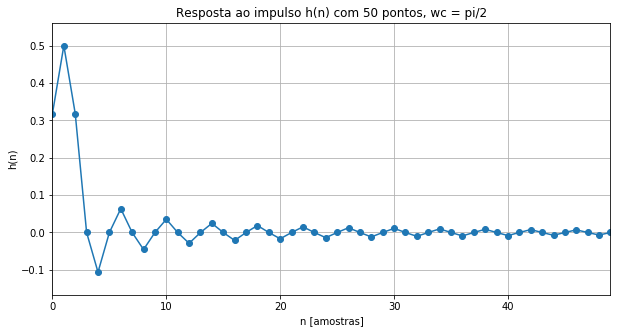

In [4]:
plt.figure(figsize=(10, 5))
plt.plot(h1, 'o-')
plt.title('Resposta ao impulso h(n) com 50 pontos, wc = pi/2')
plt.xlabel('n [amostras]')
plt.ylabel('h(n)')
plt.margins(0, 0.1)
plt.grid(which='both', axis='both')
plt.show()

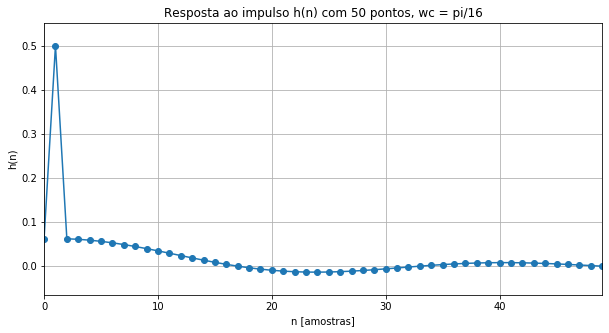

In [5]:
plt.figure(figsize=(10, 5))
plt.plot(h2, 'o-')
plt.title('Resposta ao impulso h(n) com 50 pontos, wc = pi/16')
plt.xlabel('n [amostras]')
plt.ylabel('h(n)')
plt.margins(0, 0.1)
plt.grid(which='both', axis='both')
plt.show()

In [6]:
# Funcoes auxiliares

# Funcao que monta a matriz toeplitz
# para resolver o sistema de equacoes
def convm(x, p):
    padding = np.zeros(p, x.dtype)
    
    first_col = x
    first_row = np.r_[x[0], padding]
    
    conv_matrix = linalg.toeplitz(first_col, first_row)
    
    return conv_matrix

def autocorr(x):
    r_hat = np.zeros((num_samples))
    
    for k in range(num_samples):
        for n in range(num_samples):
            # segundo a definição do livro (ex. C3.2)
            r_hat[k] += (x[n] * np.conj(x[n - k]))

        r_hat[k] /= num_samples
        
    return r_hat

In [7]:
# Definindo a funcao que implementa
# a aproximacao de Pade segundo a
# figura 4.3 do livro

def pade(x, p, q):  
    if (p + q) >= x.shape[0]:
        print('Erro: Modelo com ordem muito grande. Tente novamente.')
    
    else:
        # Amostrando a resposta ao impulso
        pade_x = x[:(p + q + 1)]
        
        # Gerando a matriz toeplitz para
        # o sistema de equacoes
        x_matrix = convm(pade_x, p)
        
        # Descobrindo os parametros a(k)
        # de acordo com as equacoes sem dependencia
        # de b(k)
        a_A = x_matrix[(q + 1):(q + p + 1), 1:(p + 1)]
        a_b = x_matrix[(q + 1):(q + p + 1), 0]        
        a = np.linalg.solve(a_A, a_b)
        a = a.reshape((a.shape[0], 1))
        
        # Descobrindo os parametros b(k)
        # de acordo com os valores de a(k)
        # calculados acima
        b_A = x_matrix[:(q + 1), :]        
        b_b = np.vstack(([1], a))        
        b = np.dot(b_A, b_b)
        
        # Contornando o problema de deixar os
        # arrays vazios
        if a.shape[0] == 0:
            a = [1]
        elif b.shape[0] == 0:
            b = [1]

        return a, b

In [8]:
# Definindo a funcao que implementa
# o metodo de Prony segundo a
# figura 4.10 do livro

# PRECISA DE REVISÃO
def prony(x, p, q):
    N = x.shape[0]
    if (p + q) >= N:
        print('Erro: Modelo com ordem muito grande. Tente novamente.')
    
    else:
        # Gerando a matriz toeplitz para
        # o sistema de equacoes
        x_matrix = convm(x, p)
        
        # Descobrindo os parametros a(k)
        # de acordo com as equacoes sem dependencia
        # de b(k)
        a_A = x_matrix[q:(N + p - 1), 0:p]
        a_b = x_matrix[(q + 1):(N + p), 0]        
        a = np.linalg.solve(a_A, a_b)
        a = a.reshape((a.shape[0], 1))
        print(a)
        
        # Descobrindo os parametros b(k)
        # de acordo com os valores de a(k)
        # calculados acima
        b_A = x_matrix[:(q + 1), :]        
        b_b = np.vstack(([1], a))        
        b = np.dot(b_A, b_b)
        print(b)
            
        # Para o calculo do erro
        err_m1 = x[(q + 1):N].T
        err_m2 = x_matrix[(q + 1):N, :]
        err = np.dot(np.dot(err_m1, err_m2), a)
        print(err)
        
        # Contornando o problema de deixar os
        # arrays vazios
        if a.shape[0] == 0:
            a = [1]
        elif b.shape[0] == 0:
            b = [1]
        
        return a, b, err

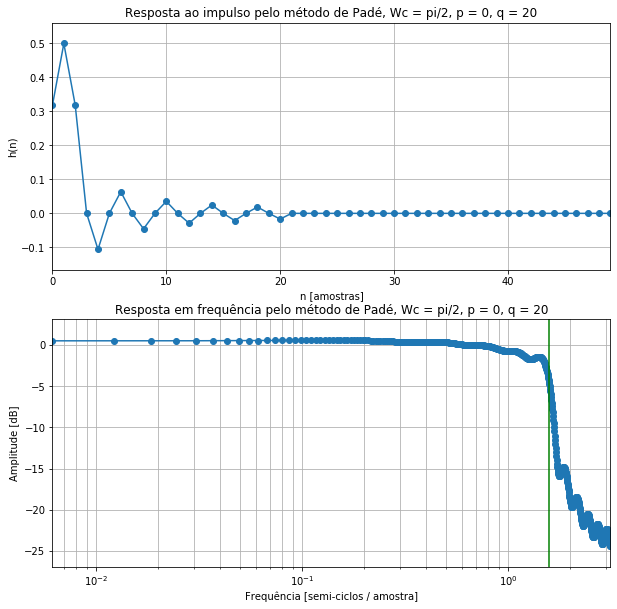

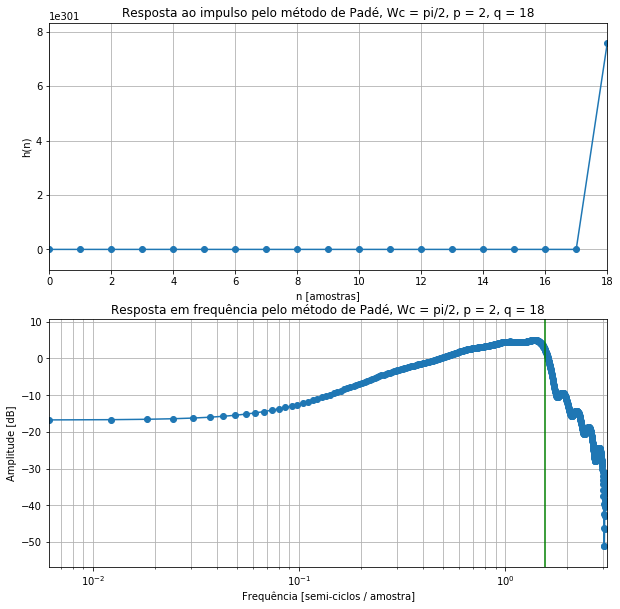

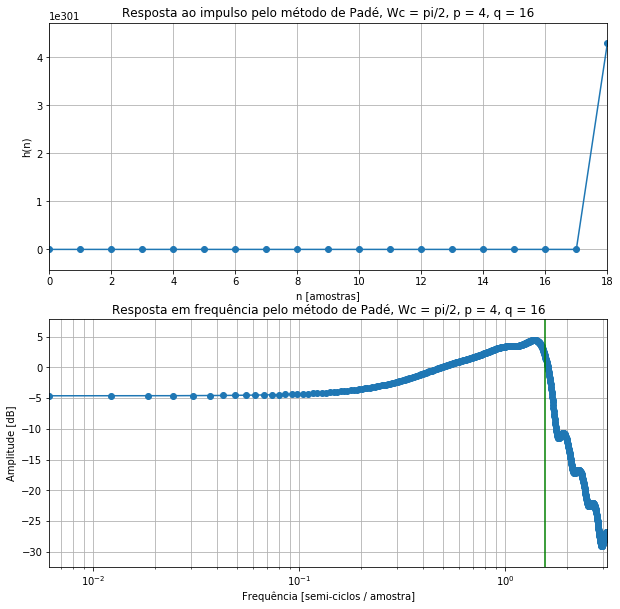

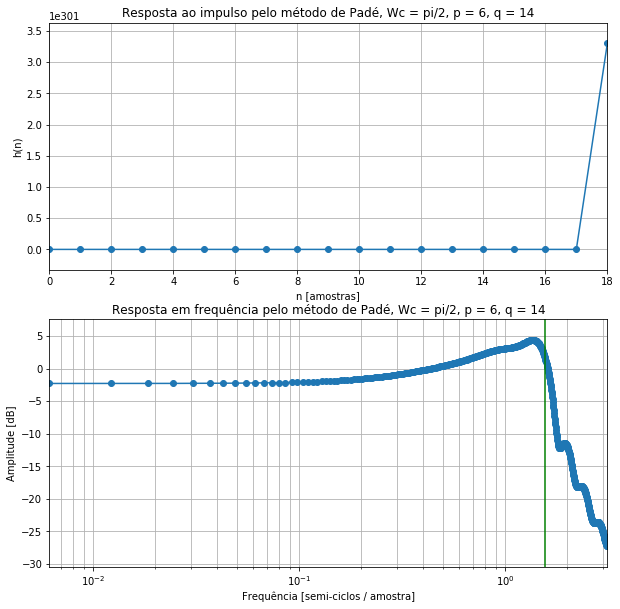

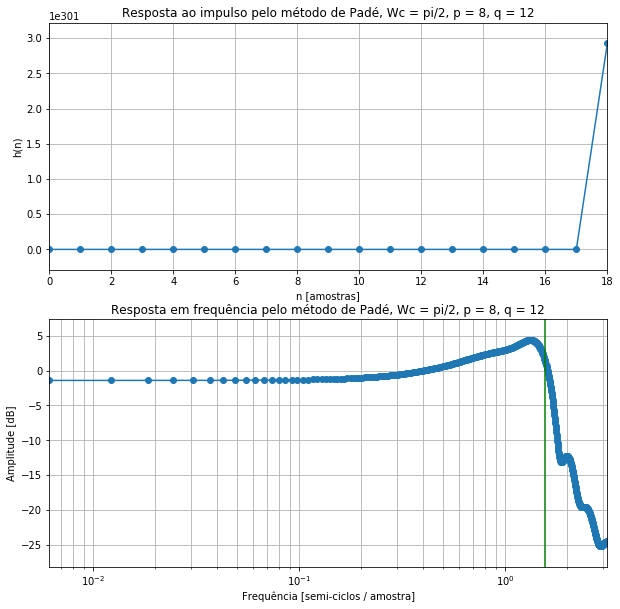

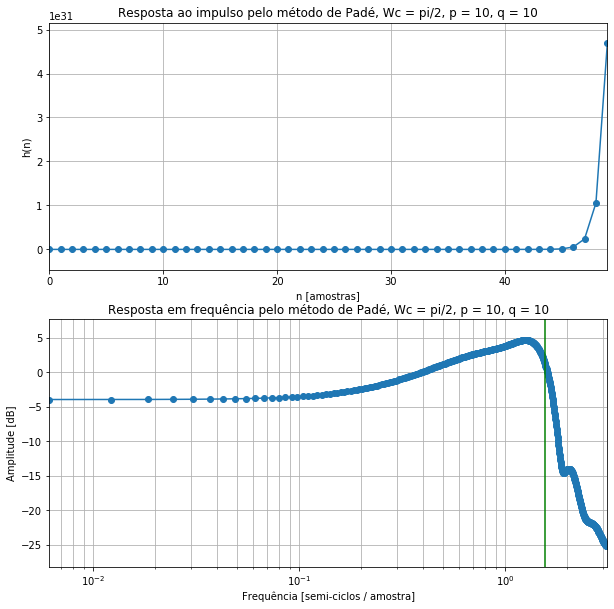

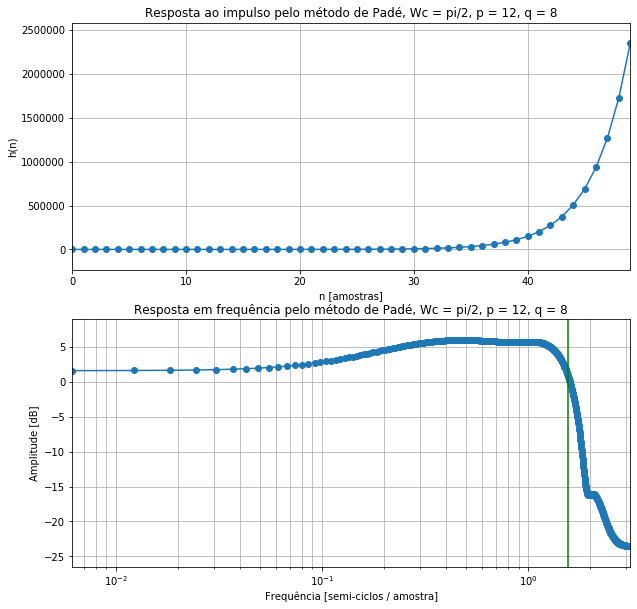

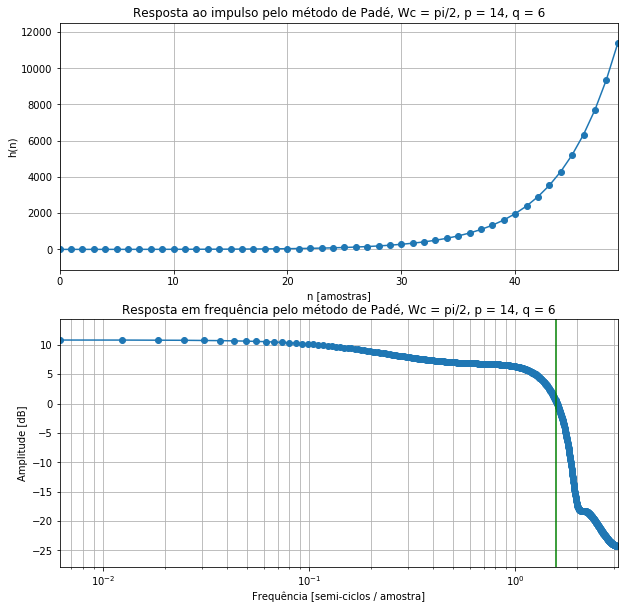

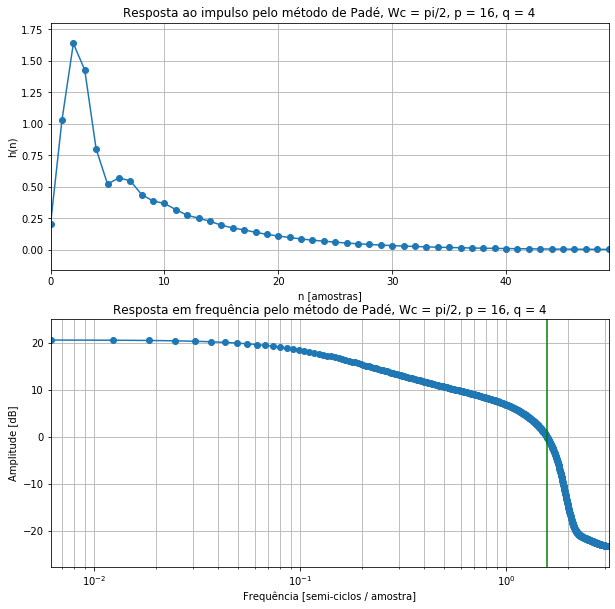

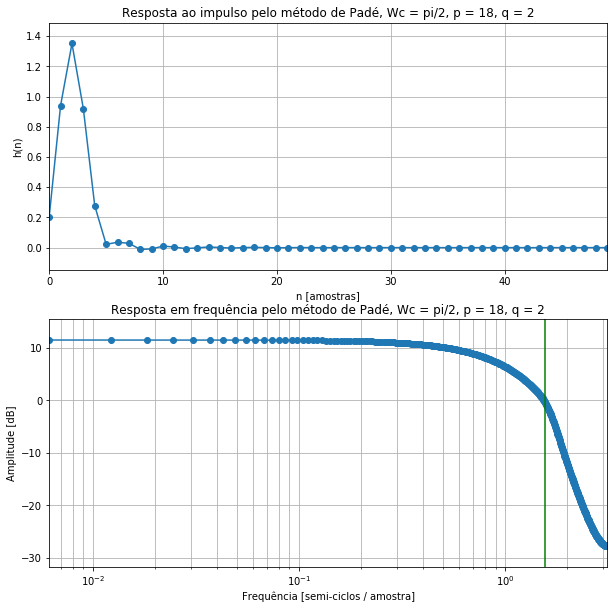

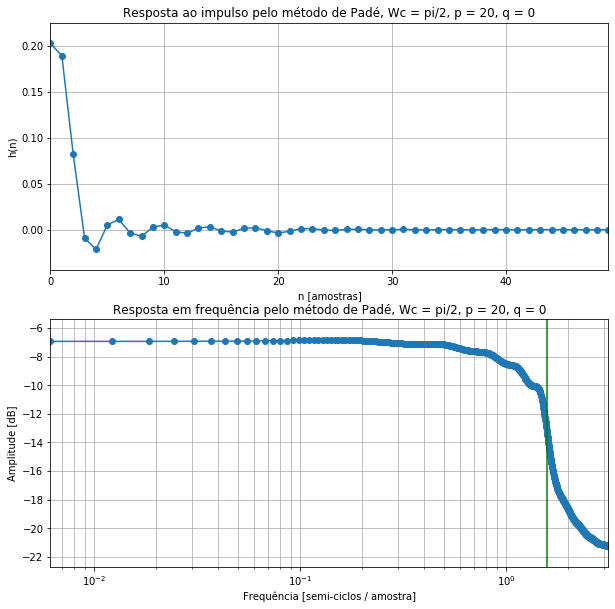

In [9]:
# Aplicando Pade para cada conjunto
# de valores p, q para wc = pi/2

impulse = np.zeros((num_samples))
impulse[0] = 1

a1_pade = {}
b1_pade = {}
H1_pade = {}
w1_pade = {}
h1_pade = {}

for p in range(0, 22, 2):
    q = 20 - p    
    a1_pade[p], b1_pade[p] = pade(h1, p, q)
    w1_pade[p], H1_pade[p] = signal.freqz(b1_pade[p], a1_pade[p])
    
    # Tratamento para os parametros de entrada da
    # funcao signal.lfilter
    a1_pade[p] = np.reshape(a1_pade[p], len(a1_pade[p]))
    b1_pade[p] = np.reshape(b1_pade[p], len(b1_pade[p]))
    
    # Propagando um impulso unitario pelo filtro
    # para descobrir h(n) do metodo de Pade extrapolado
    h1_pade[p] = signal.lfilter(b1_pade[p], a1_pade[p], impulse)
    
    # Visualizacao da resposta ao impulso e da
    # resposta em frequencia
    plt.figure(figsize=(10, 10))
    
    plt.subplot(2, 1, 1)
    plt.plot(h1_pade[p], 'o-')
    plt.title('Resposta ao impulso pelo método de Padé, Wc = pi/2, p = {}, q = {}'.format(p, q))
    plt.xlabel('n [amostras]')
    plt.ylabel('h(n)')
    plt.margins(0, 0.1)
    plt.grid(which='both', axis='both')
    
    plt.subplot(2, 1, 2)
    plt.semilogx(w1_pade[p], 20 * np.log10(abs(H1_pade[p])), 'o-')
    plt.title('Resposta em frequência pelo método de Padé, Wc = pi/2, p = {}, q = {}'.format(p, q))
    plt.xlabel('Frequência [semi-ciclos / amostra]')
    plt.ylabel('Amplitude [dB]')
    plt.margins(0, 0.1)
    plt.grid(which='both', axis='both')
    plt.axvline(wc1, color='green')
    
    plt.show()

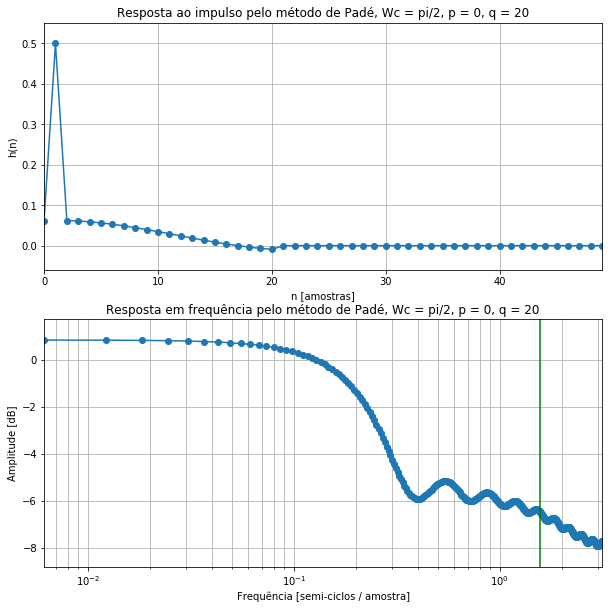

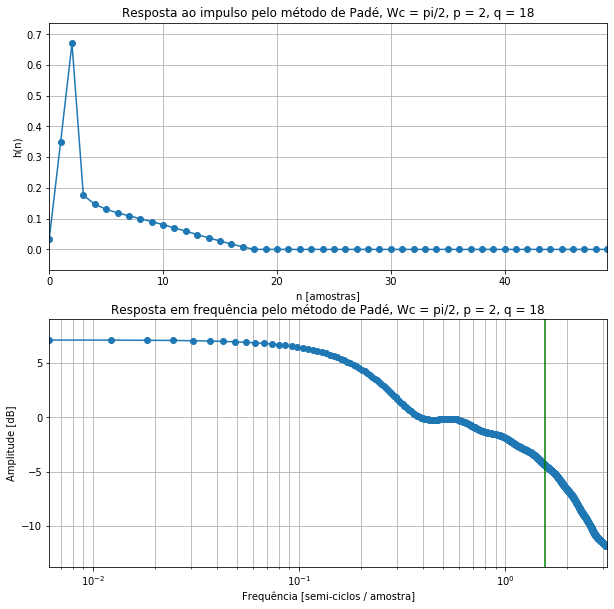

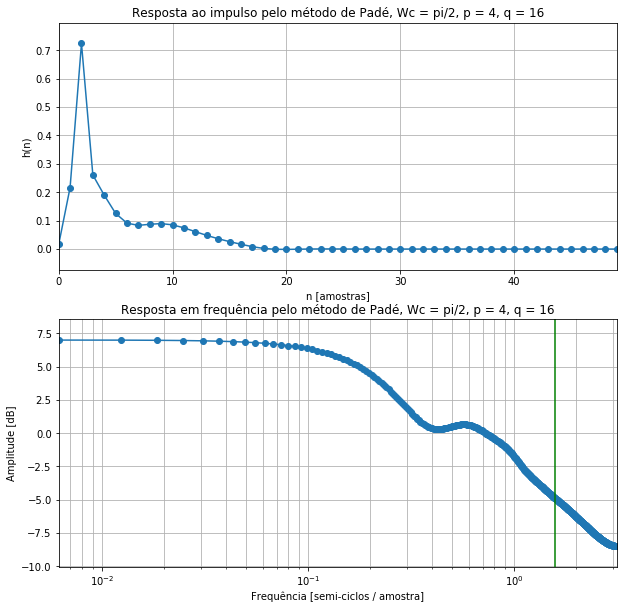

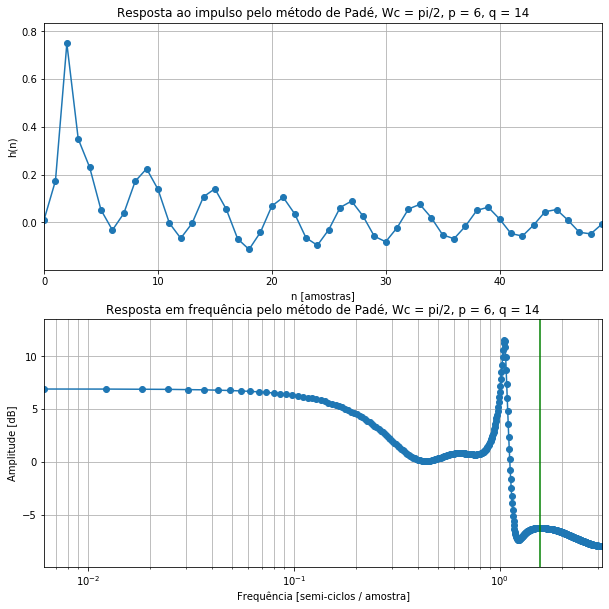

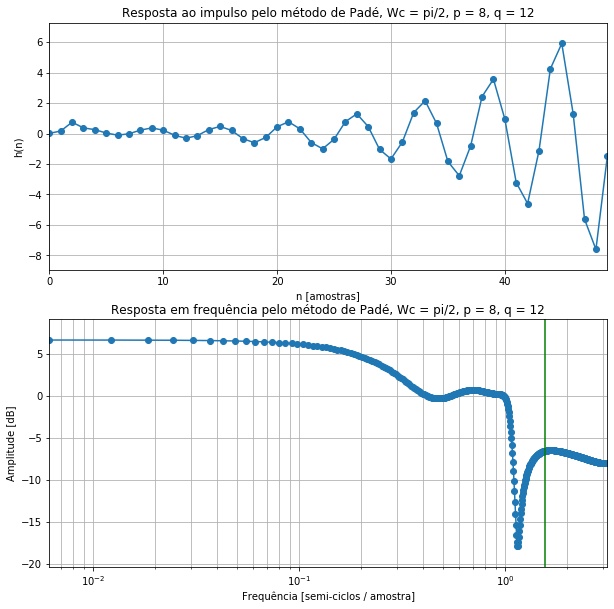

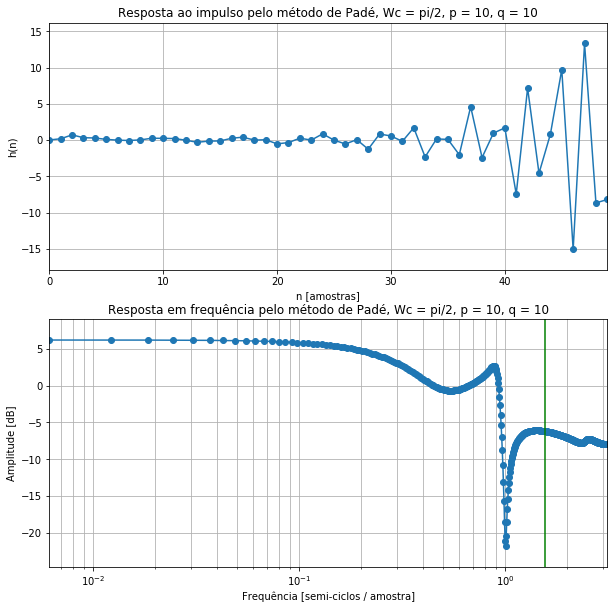

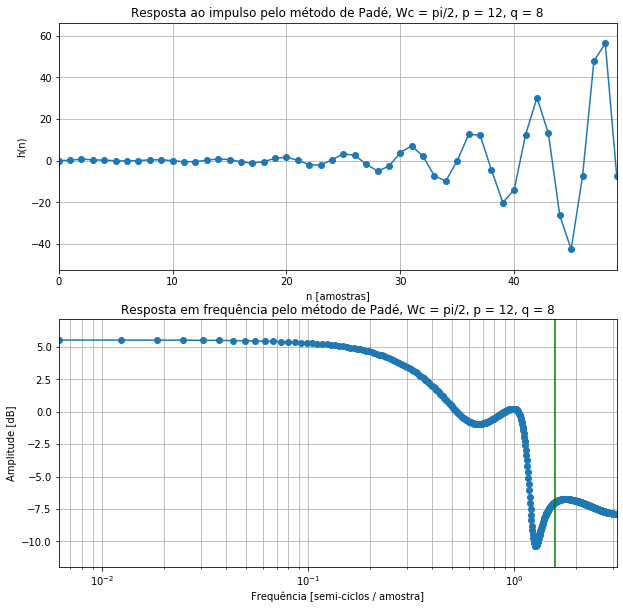

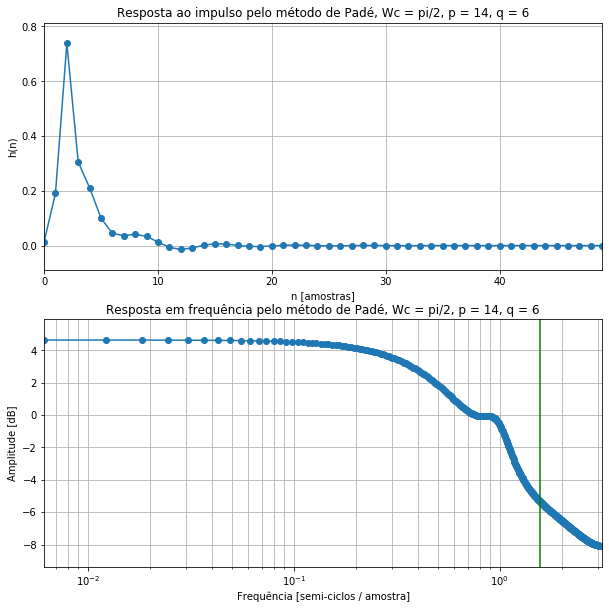

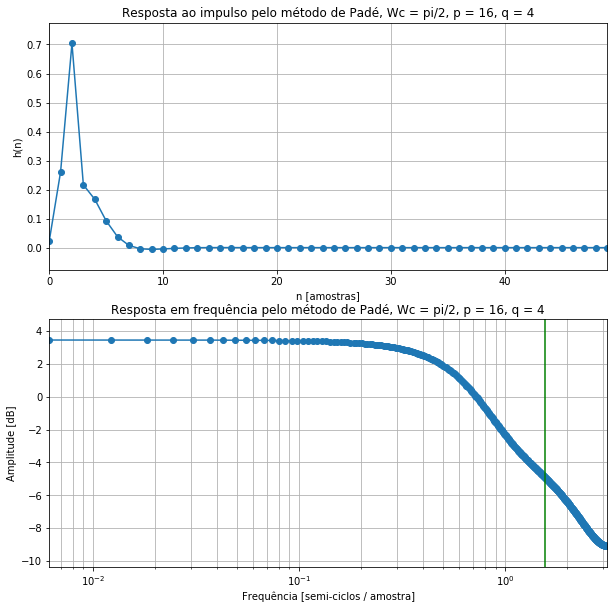

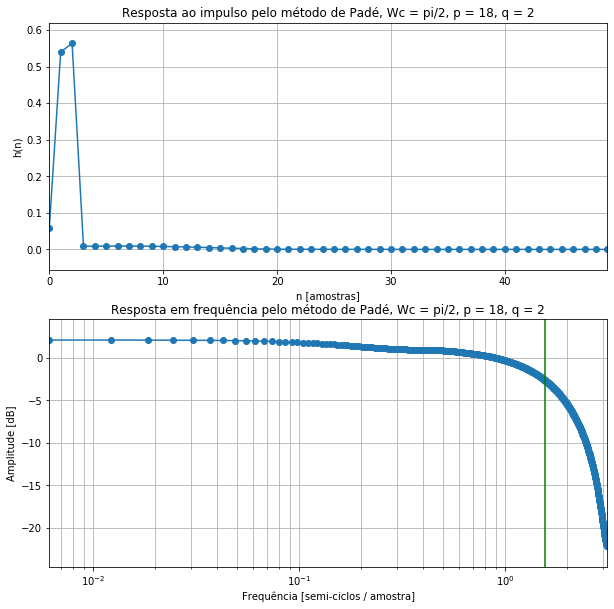

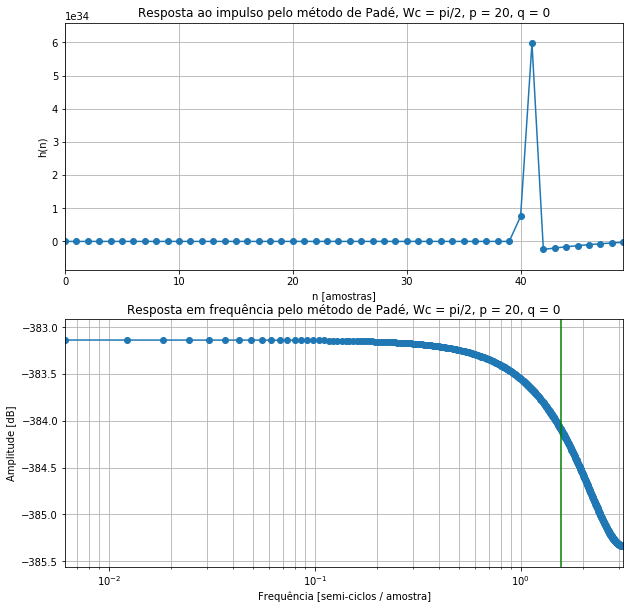

In [10]:
# Aplicando Pade para cada conjunto
# de valores p, q para wc = pi/16

a2_pade = {}
b2_pade = {}
H2_pade = {}
w2_pade = {}
h2_pade = {}

for p in range(0, 22, 2):
    q = 20 - p    
    a2_pade[p], b2_pade[p] = pade(h2, p, q)
    w2_pade[p], H2_pade[p] = signal.freqz(b2_pade[p], a2_pade[p])
    
    # Tratamento para os parametros de entrada da
    # funcao signal.lfilter
    a2_pade[p] = np.reshape(a2_pade[p], len(a2_pade[p]))
    b2_pade[p] = np.reshape(b2_pade[p], len(b2_pade[p]))
    
    # Propagando um impulso unitario pelo filtro
    # para descobrir h(n) do metodo de Pade extrapolado
    h2_pade[p] = signal.lfilter(b2_pade[p], a2_pade[p], impulse)
    
    # Visualizacao da resposta ao impulso e da
    # resposta em frequencia
    plt.figure(figsize=(10, 10))
    
    plt.subplot(2, 1, 1)
    plt.plot(h2_pade[p], 'o-')
    plt.title('Resposta ao impulso pelo método de Padé, Wc = pi/2, p = {}, q = {}'.format(p, q))
    plt.xlabel('n [amostras]')
    plt.ylabel('h(n)')
    plt.margins(0, 0.1)
    plt.grid(which='both', axis='both')
    
    plt.subplot(2, 1, 2)
    plt.semilogx(w2_pade[p], 20 * np.log10(abs(H2_pade[p])), 'o-')
    plt.title('Resposta em frequência pelo método de Padé, Wc = pi/2, p = {}, q = {}'.format(p, q))
    plt.xlabel('Frequência [semi-ciclos / amostra]')
    plt.ylabel('Amplitude [dB]')
    plt.margins(0, 0.1)
    plt.grid(which='both', axis='both')
    plt.axvline(wc1, color='green')
    
    plt.show()

In [11]:
# # Aplicando Prony para cada conjunto
# # de valores p, q para wc = pi/2

# a1_prony = {}
# b1_prony = {}
# H1_prony = {}
# w1_prony = {}
# h1_prony = {}

# for p in range(0, 22, 2):
#     q = 20 - p
    
#     a1_prony[p], b1_prony[p] = prony(h1, p, q)
#     w1_prony[p], H1_prony[p] = signal.freqz(b1_prony[p], a1_prony[p])
    
#     # Tratamento para os parametros de entrada da
#     # funcao signal.lfilter
#     a1_prony[p] = np.reshape(a1_prony[p], len(a1_prony[p]))
#     b1_prony[p] = np.reshape(b1_prony[p], len(b1_prony[p]))
    
#     # Propagando um impulso unitario pelo filtro
#     # para descobrir h(n) do metodo de Pade extrapolado
#     h1_prony[p] = signal.lfilter(b1_prony[p], a1_prony[p], impulse)
    
#     # Visualizacao da resposta ao impulso e da
#     # resposta em frequencia
#     plt.figure(figsize=(10, 10))
    
#     plt.subplot(2, 1, 1)
#     plt.plot(h1_prony[p], 'o-')
#     plt.title('Resposta ao impulso pelo método de Padé, Wc = pi/2, p = {}, q = {}'.format(p, q))
#     plt.xlabel('n [amostras]')
#     plt.ylabel('h(n)')
#     plt.margins(0, 0.1)
#     plt.grid(which='both', axis='both')
    
#     plt.subplot(2, 1, 2)
#     plt.semilogx(w1_prony[p], 20 * np.log10(abs(H1_prony[p])), 'o-')
#     plt.title('Resposta em frequência pelo método de Padé, Wc = pi/2, p = {}, q = {}'.format(p, q))
#     plt.xlabel('Frequência [semi-ciclos / amostra]')
#     plt.ylabel('Amplitude [dB]')
#     plt.margins(0, 0.1)
#     plt.grid(which='both', axis='both')
#     plt.axvline(wc1, color='green')
    
#     plt.show()

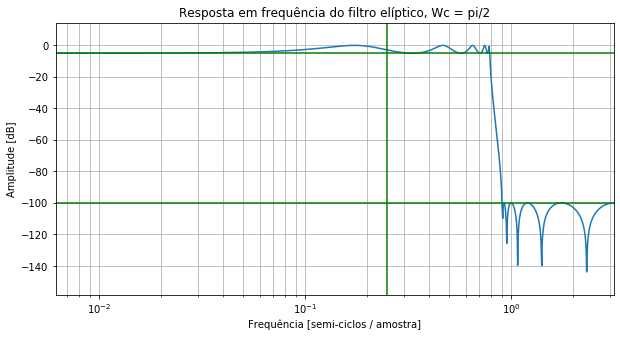

In [12]:
# Projetando o filtro eliptico

wc_ellip = 1 / 4
Rp = 5
Rs = 100
order = 10

b_ellip, a_ellip = signal.ellip(order, Rp, Rs, wc_ellip, btype ='lowpass', analog=False, output='ba')
w_ellip, H_ellip = signal.freqz(b_ellip, a_ellip)

plt.figure(figsize=(10, 5))
plt.semilogx(w_ellip, 20 * np.log10(abs(H_ellip)))
plt.title('Resposta em frequência do filtro elíptico, Wc = pi/2')
plt.xlabel('Frequência [semi-ciclos / amostra]')
plt.ylabel('Amplitude [dB]')
plt.margins(0, 0.1)
plt.grid(which='both', axis='both')
plt.axvline(wc_ellip, color='green')
plt.axhline(-Rs, color='green')
plt.axhline(-Rp, color='green')
plt.show()